# Intercalated graphene
In this example, we extract the self-energies and Eliashberg function of Si-intercalated, Li-doped graphene.

Data have been provided with permission for re-use, originating from:
https://journals.aps.org/prb/abstract/10.1103/PhysRevB.97.085132


In [ ]:
%load_ext autoreload
%autoreload 2

# Necessary packages
import xarpes
import matplotlib.pyplot as plt
import os

# Default plot configuration from xarpes.plotting.py
xarpes.plot_settings('default')

In [ ]:
script_dir = xarpes.set_script_dir()

dfld = 'data_sets'    # Folder containing the data
flnm = 'graphene_152' # Name of the file
extn = '.ibw'         # Extension of the file

data_file_path = os.path.join(script_dir, dfld, flnm + extn)

The following cell instantiates band map class object based on the Igor Binary Wave (ibw) file. The subsequent cell illustrates how a band map object could be instantiated with NumPy arrays instead. Only one of the cells will have to be executed to populate the band map object.

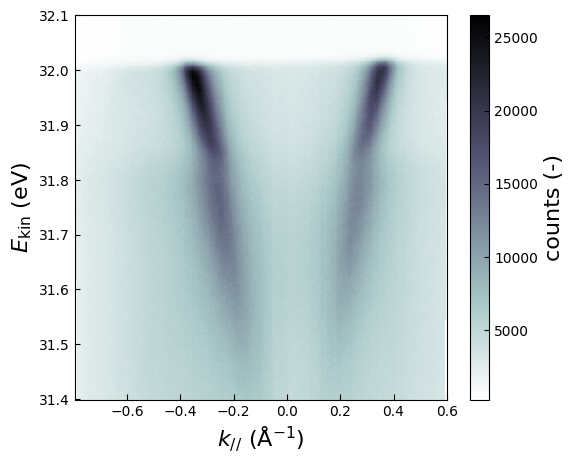

In [ ]:
%matplotlib inline

bmap = xarpes.BandMap.from_ibw_file(data_file_path, energy_resolution=0.01, 
        angle_resolution=0.1, temperature=50)

bmap.shift_angles(shift=-2.28)

fig = bmap.plot(abscissa='momentum', ordinate='kinetic_energy', size_kwargs=dict(w=6, h=5))

In [ ]:
# %matplotlib inline

# import numpy as np

# intensities= np.load(os.path.join(script_dir, dfld, "graphene_152_intensities.npy"))
# angles = np.load(os.path.join(script_dir, dfld, "graphene_152_angles.npy"))
# ekin = np.load(os.path.join(script_dir, dfld, "graphene_152_ekin.npy"))

# bmap = xarpes.BandMap.from_np_arrays(intensities, angles, ekin, 
#         energy_resolution=0.01, angle_resolution=0.1, temperature=50)

# bmap.shift_angles(shift=-2.28)

# fig = bmap.plot(abscissa='momentum', ordinate='kinetic_energy', size_kwargs=dict(w=6, h=5))

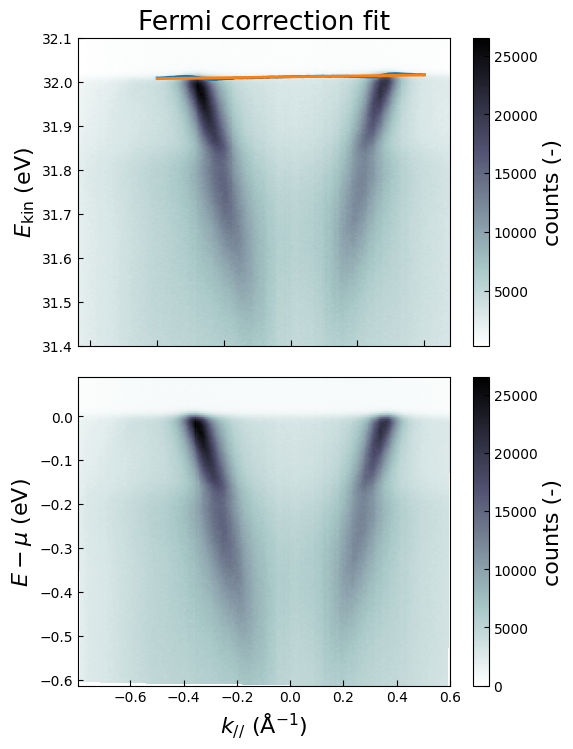

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

bmap.correct_fermi_edge(
      hnuminPhi_guess=32, background_guess=1e2,
      integrated_weight_guess=1e3, angle_min=-10, angle_max=10,
      ekin_min=31.96, ekin_max=32.08, true_angle=0.0,
      ax=ax[0], show=False, fig_close=False)

bmap.plot(ordinate='electron_energy', abscissa='momentum',
      ax=ax[1], show=False, fig_close=False)

# Figure customization
ax[0].set_xlabel(''); ax[0].set_xticklabels([])
ax[0].set_title('Fermi correction fit')
fig.subplots_adjust(top=0.92, hspace=0.1)
plt.show()

print('The optimised hnu - Phi=' + f'{bmap.hnuminPhi:.4f}' + ' +/- '
      + f'{1.96 * bmap.hnuminPhi_std:.5f}' + ' eV.')

# fig = bmap.plot(ordinate='kinetic_energy', abscissa='angle')

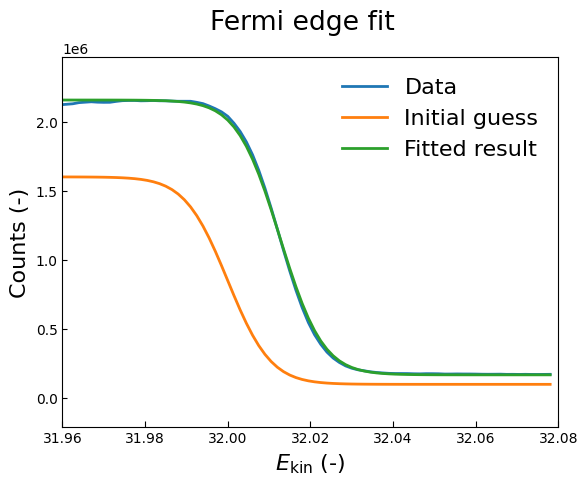

In [ ]:
%matplotlib inline

fig = bmap.fit_fermi_edge(hnuminPhi_guess=32, background_guess=1e5,
                          integrated_weight_guess=1.5e6, angle_min=-10,
                          angle_max=10, ekin_min=31.96, ekin_max=32.08,
                          show=True, title='Fermi edge fit')

print('The optimised hnu - Phi=' + f'{bmap.hnuminPhi:.4f}' + ' +/- '
      + f'{1.96 * bmap.hnuminPhi_std:.5f}' + ' eV.')

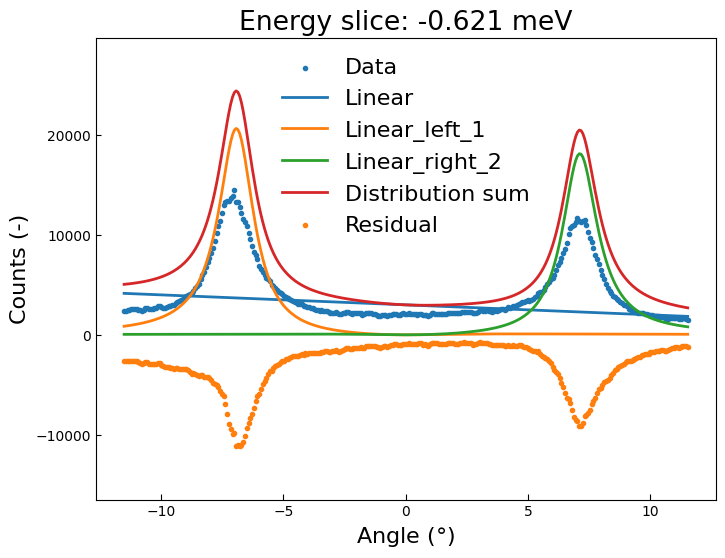

In [ ]:
%matplotlib inline

angle_min = -11.5
angle_max = 11.5

energy_range = [-0.246, 0.01]
energy_value = 0.0

mdcs = xarpes.MDCs(*bmap.mdc_set(angle_min, angle_max, energy_range=energy_range))

guess_dists = xarpes.CreateDistributions([
xarpes.Linear(offset=3.0e3, slope=-100),
xarpes.SpectralLinear(amplitude=1.5e3, peak=-6.9, broadening=0.015,
                      name='Linear_left', index='1'),
xarpes.SpectralLinear(amplitude=1.3e3, peak=7.1, broadening=0.015,
                      name='Linear_right', index='2')
])

k_diff = -0.13

import numpy as np

# Eq. S13 of the supplemental information.
# Currently E_kin cannot be supplied as an argument, so it is fixed to hnuminPhi
mat_el = lambda x: (1 + k_diff / np.sqrt(k_diff ** 2 + bmap.hnuminPhi *
                        np.sin(np.deg2rad(x)) ** 2 / xarpes.PREF))

mat_args = {}

fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

fig = mdcs.visualize_guess(distributions=guess_dists, energy_value=energy_value, 
                           matrix_element=mat_el, matrix_args=mat_args, ax=ax)

**Note on interactive figures**
- The interactive figure might not work inside the Jupyter notebooks, despite our best efforts to ensure stability.
- As a fallback, the user may switch from "%matplotlib widget" to "%matplotlib qt", after which the figure should pop up in an external window.
- For some package versions, a static version of the interactive widget may spuriously show up inside other cells. In that case, uncomment the #get_ipython()... line in the first cell for your notebooks.

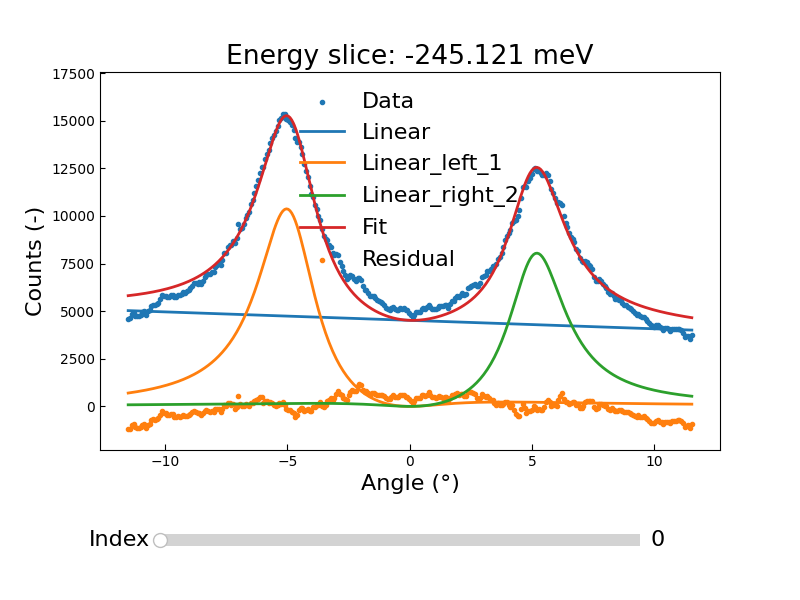

In [ ]:
%matplotlib widget

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

mdcs = xarpes.MDCs(*bmap.mdc_set(angle_min, angle_max, energy_range=energy_range))

fig = mdcs.fit_selection(distributions=guess_dists, 
                         matrix_element=mat_el, matrix_args=mat_args, ax=ax)

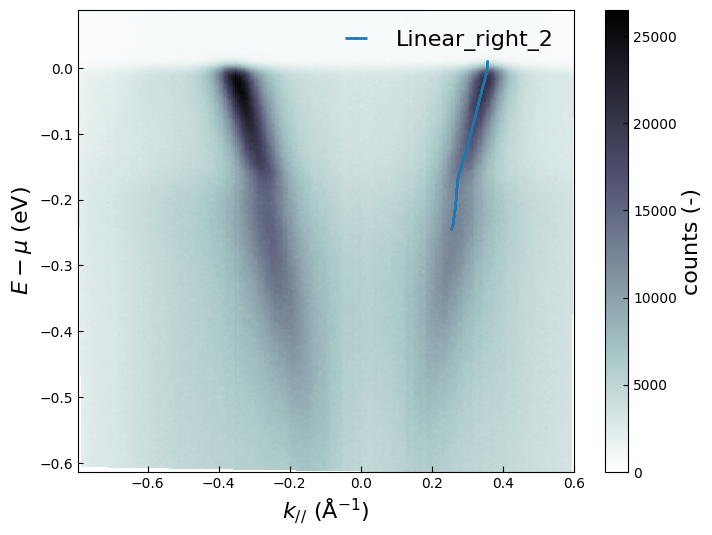

In [ ]:
%matplotlib inline

plt.rcParams['lines.markersize'] = 0.8

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

self_energy = xarpes.SelfEnergy(*mdcs.expose_parameters(select_label='Linear_right_2',
                                fermi_velocity=2.851291959, fermi_wavevector=0.357807))

self_energies = xarpes.CreateSelfEnergies([self_energy])

fig = bmap.plot(abscissa='momentum', ordinate='electron_energy', ax=ax,
                self_energies=self_energies)

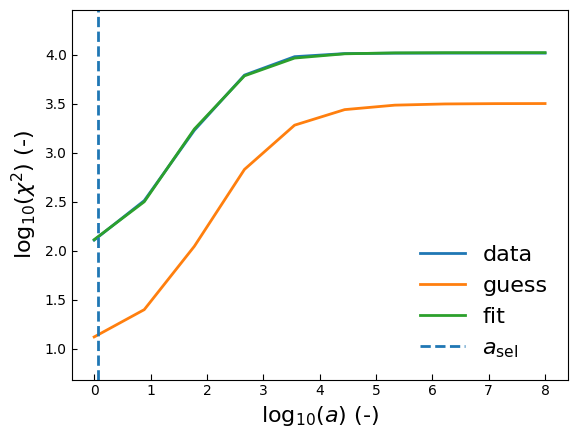

In [ ]:
%matplotlib inline

fig, spectrum, model, omega_range, aval_select = self_energy.extract_a2f(
        omega_min=0.5, omega_max=250, omega_num=250, omega_I=50, omega_M=200,
        omega_S=1, aval_min=1.0, aval_max=9.0, aval_num=10, method="chi2kink", 
        parts="both", ecut_left=0.0, ecut_right=None, t_criterion=1e-8, 
        sigma_svd=1e-4, iter_max=1e4, lambda_el=0.0, W=1500, h_n=0.1062861,
        impurity_magnitude=120.94606, power=4, f_chi_squared=None)

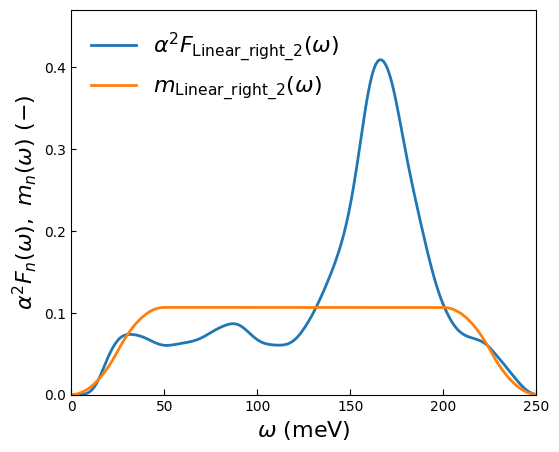

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(6, 5)); ax = fig.gca()

fig = self_energy.plot_spectra(ax=ax)

In [ ]:
with xarpes.trim_notebook_output(print_lines=10):
    spectrum, model, omega_range, aval_select, cost, params = self_energy.bayesian_loop(omega_min=0.5,
                omega_max=250, omega_num=250, omega_I=50, omega_M=200, omega_S=1.0,
                W=1500, power=4, fermi_velocity=2.8590436, fermi_wavevector=0.358010499,
                h_n=0.0802309738, impurity_magnitude=120.902261, lambda_el=0,
                vary=("impurity_magnitude", "lambda_el", "fermi_wavevector", "fermi_velocity", "h_n"), 
                converge_iters=10, tole=1e-2, scale_vF=1.0, scale_imp=1.0, scale_kF=0.1, 
                scale_lambda_el=1.0, scale_hn=10.0, 
                print_lines=10)

The following cell performs some testing on the electron-electron self-energy expressions

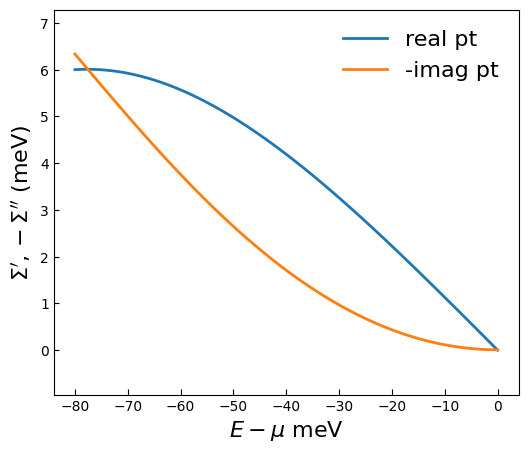

In [ ]:
%matplotlib inline

temperature = 10
k_BT = xarpes.K_B * temperature * xarpes.KILO
enel_range = np.linspace(-80, 0, 100)
lambda_el = 0.1132858
W = 150
power = 4

re, im = xarpes.SelfEnergy._el_el_self_energy(
    enel_range=enel_range,
    k_BT=k_BT,
    lambda_el=lambda_el,
    W=W,
    power=power)

plt.figure(figsize=(6, 5))
plt.xlabel(r'$E-\mu$ meV')
plt.ylabel(r"$\Sigma', -\Sigma''$ (meV)")
plt.plot(enel_range, re, label='real pt')
plt.plot(enel_range,im, label='-imag pt')
plt.legend()
plt.show()

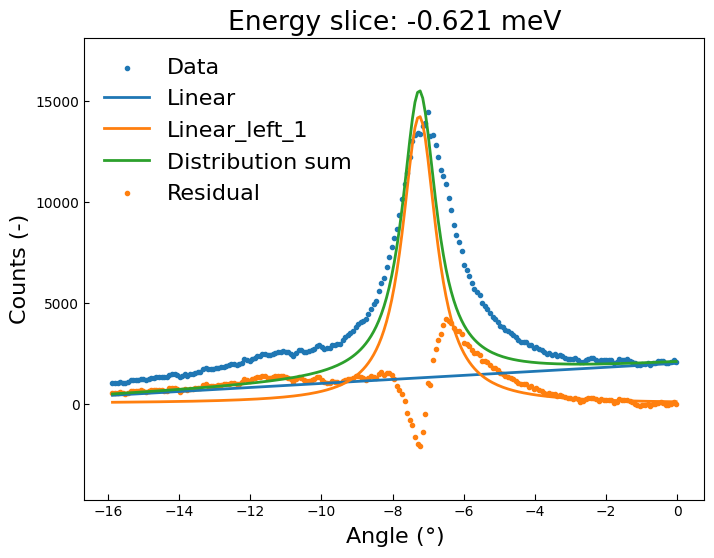

In [ ]:
%matplotlib inline

angle_min2 = -1e6
angle_max2 = 0

plt.rcParams['lines.markersize'] = 3.0

mdc2 = xarpes.MDCs(*bmap.mdc_set(angle_min2, angle_max2, energy_range=energy_range))

guess_dists2 = xarpes.CreateDistributions([
xarpes.Linear(offset=2.0e3, slope=100),
xarpes.SpectralLinear(amplitude=450, peak=-7.25, broadening=0.01,
                      name='Linear_left', index='1'),
])

fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

fig = mdc2.visualize_guess(distributions=guess_dists2, energy_value=0, ax=ax)

In [ ]:
# Fit without showing output

fig = mdc2.fit_selection(distributions=guess_dists2, show=False, fig_close=True)

self_left = xarpes.SelfEnergy(*mdc2.expose_parameters(select_label='Linear_left_1',
fermi_velocity=-2.67, fermi_wavevector=-0.354))

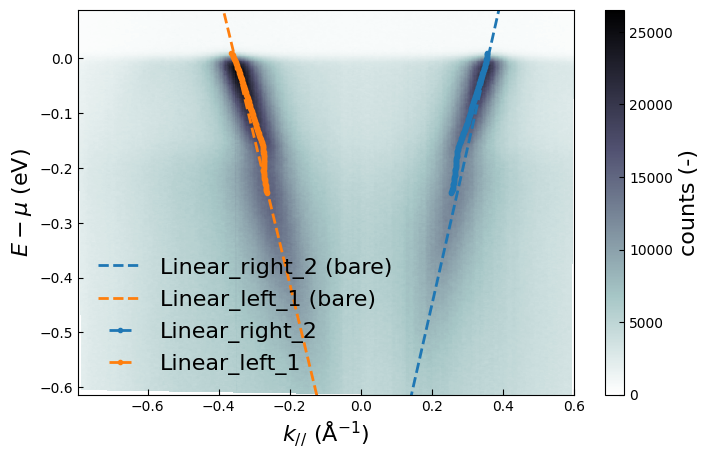

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(8, 5)); ax = fig.gca()

self_energies= xarpes.CreateSelfEnergies([
    self_energy, self_left
])

fig = bmap.plot(abscissa='momentum', ordinate='electron_energy',
                self_energies=self_energies, plot_dispersions='full',
                ax=ax)

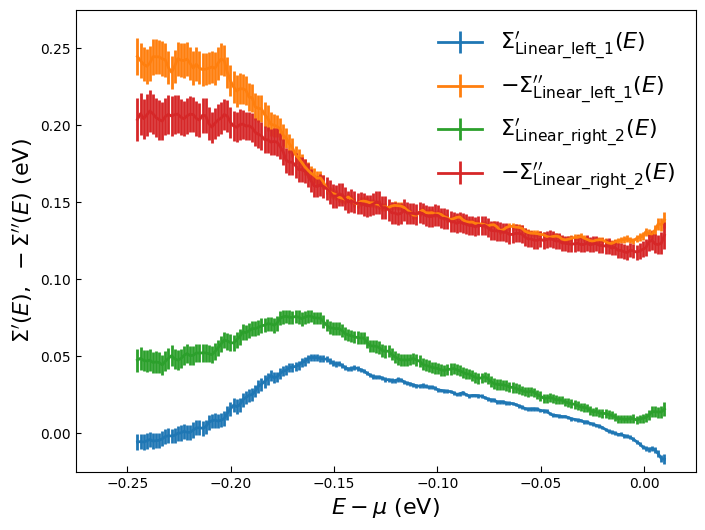

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

self_left.plot_both(ax=ax, show=False, fig_close=False)
self_energy.plot_both(ax=ax, show=False, fig_close=False)

ax.set_xlim([-0.275, 0.025])
ax.set_ylim([-0.025, 0.275])

plt.legend(); plt.show()

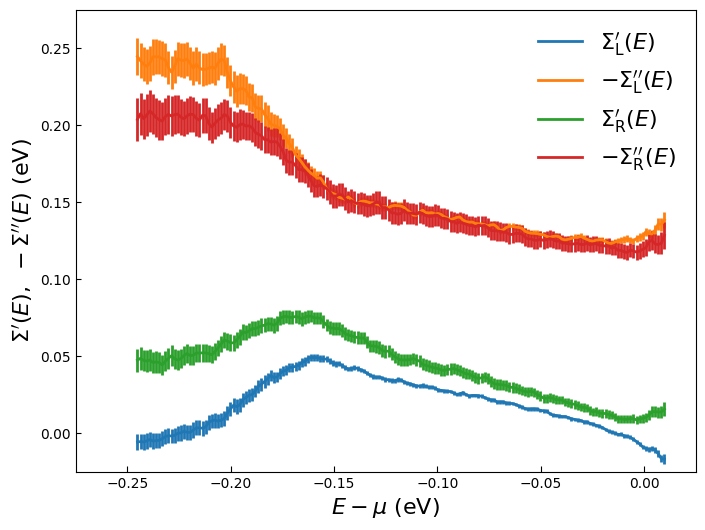

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(8, 6)); ax = fig.gca()

self_left.plot_both(ax=ax, show=False, fig_close=False)
self_energy.plot_both(ax=ax, show=False, fig_close=False)

ax.set_xlim([-0.275, 0.025]); ax.set_ylim([-0.025, 0.275])

# Replace labels with custom labels
left_real, left_imag, right_real, right_imag = ax.get_lines()

labels = [
    r"$\Sigma_{\mathrm{L}}'(E)$", r"$-\Sigma_{\mathrm{L}}''(E)$",
    r"$\Sigma_{\mathrm{R}}'(E)$", r"$-\Sigma_{\mathrm{R}}''(E)$",
]

ax.legend([left_real, left_imag, right_real, right_imag], labels)

plt.show()